In [82]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import os
import sys
import argparse

import random
import torch.nn as nn





# Creating the model definition:

Has options for:

1.   FruitFly
2.   KO Network
3.   DO Network

Also has a flag whether you want to return the hidden activations


In [83]:
# creating model definition
class ModelNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModelNetwork, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)  # First linear layer
        self.relu = nn.ReLU()                             # ReLU activation
        self.layer2 = nn.Linear(hidden_size, output_size) # Second linear layer
        self.sigmoid = nn.Sigmoid()                       # Sigmoid activation

    def forward(self, x, knockout=None, dropout=False, use_control=False, return_activation=False):
        x = self.layer1(x)

        # adding knockout condition for "knocking out" the ith unit, None for avoiding it
        if dropout == False:
          if knockout is not None:
              x[:, knockout] = 0
        # this is for the DO condition
        else:
            if use_control == False: # when using control with knockout don't use any dropout
              random_unit = random.randint(0, x.size(1) - 1)
              x[:, random_unit] = 0

        if return_activation:
          return x

        # x = self.relu(x)
        x = self.layer2(x)
        # x = self.sigmoid(x)
        return x


In [84]:
# function for generating data
# returns both data and labels
def generate_data(model, data_size, use_noise = True):
    res_data, res_labels = [], []

    for i in range(17):
        inputs = torch.randn(data_size, 50)
        res_data.append(inputs)
        if i == 0:
            fruit_fly_behavior = model(inputs, None)
        else:
            fruit_fly_behavior = model(inputs, i-1) # knocking out the i-1th hidden unit

        # add noise with sigma = 0.05
        if use_noise:
          noise = 0.05 * torch.randn_like(fruit_fly_behavior)
          fruit_fly_behavior += noise
        res_labels.append(fruit_fly_behavior)

    return res_data, res_labels


In [85]:
# initializing FruitFlyNetwork model
FruitFlyNetwork = ModelNetwork(50, 16, 1)


In [86]:
# train data --> idx 0 is the control, idx 1-16 is the knockout
train_data, train_labels = generate_data(FruitFlyNetwork, 1000)
# test data --> idx 0 is the control, idx 1-16 is the knockout
test_data, test_labels = generate_data(FruitFlyNetwork, 500)


#**Solutions for Q2**

## 2.1

In [87]:
# initializing KO Network
KONetwork = ModelNetwork(50, 16, 1)


## 2.2

In [88]:
def r2_score(targets, outputs):
    ss_total = ((targets - targets.mean())**2).sum()
    ss_res = ((targets - outputs)**2).sum()
    r2_score = 1 - (ss_res/ss_total)

    return r2_score


In [89]:
# Setting up the training loop
# passing idx 0 only as that is the control data
criterion = nn.MSELoss()
optimizer = optim.Adam(KONetwork.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    # print(f"Running for epoch: {epoch+1}")
    # Forward pass
    outputs = KONetwork(train_data[0])
    loss = criterion(outputs, train_labels[0])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch+1)%10 == 0:

        print(f"Loss for epoch: {epoch} is: {loss}")
        # for test data
        with torch.no_grad():
            test_outputs = KONetwork(test_data[0])
            # r2score = r2_score(test_labels[0], test_outputs)
            print(f"R2 Score: {r2_score(test_labels[0], test_outputs)}")


Loss for epoch: 9 is: 0.1801750510931015
R2 Score: -1.2384872436523438
Loss for epoch: 19 is: 0.11351479589939117
R2 Score: -0.5163277387619019
Loss for epoch: 29 is: 0.07321640104055405
R2 Score: -0.046636223793029785
Loss for epoch: 39 is: 0.04790483042597771
R2 Score: 0.2606646418571472
Loss for epoch: 49 is: 0.03185134008526802
R2 Score: 0.4766393303871155
Loss for epoch: 59 is: 0.02136070653796196
R2 Score: 0.6315363049507141
Loss for epoch: 69 is: 0.01412302814424038
R2 Score: 0.7498037815093994
Loss for epoch: 79 is: 0.009045916609466076
R2 Score: 0.837372362613678
Loss for epoch: 89 is: 0.005752249155193567
R2 Score: 0.895279049873352
Loss for epoch: 99 is: 0.003838013857603073
R2 Score: 0.9290162324905396


In [90]:
# calculating the final R2 score
with torch.no_grad():
            test_outputs = KONetwork(test_data[0])
            # r2score = r2_score(test_labels[0], test_outputs)
            print(f"R2 Score: {r2_score(test_labels[0], test_outputs)}")

R2 Score: 0.9290162324905396


## Solution: R^2 score after 100 epochs: **0.2504075765609741**




## 2.3

In [91]:
# initializing knockout network
KONetwork_withKnockout = ModelNetwork(50, 16, 1)

In [92]:
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(KONetwork_withKnockout.parameters(), lr=0.001)
epochs = 100
for epoch in range(epochs):
    # Shuffling datasets to add more randomness
    input_order = list(range(17))
    random.shuffle(input_order)
    for idx in input_order:
        # If idx is 0, use the control dataset,
        # else use the corresponding Knock out dataset
            batch_inputs, batch_labels = train_data[idx], train_labels[idx]
            if idx == 0:
                knockout = None
            else:
                knockout = idx-1

            outputs = KONetwork_withKnockout(batch_inputs, knockout=knockout)
            loss = criterion2(outputs, batch_labels)

            # Backward pass and optimization
            optimizer2.zero_grad()
            loss.backward(retain_graph=True)
            optimizer2.step()

    if (epoch+1)%10 == 0:

        print(f"Loss for epoch: {epoch+1} is: {loss}")
        # for test data
        with torch.no_grad():
            test_outputs = KONetwork_withKnockout(test_data[0])
            # r2score = r2_score(test_labels[0], test_outputs)
            print(f"R2 Score for control: {r2_score(test_labels[0], test_outputs)}")




Loss for epoch: 10 is: 0.018838440999388695
R2 Score for control: 0.9630845189094543
Loss for epoch: 20 is: 0.010348780080676079
R2 Score for control: 0.9634901285171509
Loss for epoch: 30 is: 0.008623631671071053
R2 Score for control: 0.9646258354187012
Loss for epoch: 40 is: 0.010970632545650005
R2 Score for control: 0.9638688564300537
Loss for epoch: 50 is: 0.009793608449399471
R2 Score for control: 0.9635323286056519
Loss for epoch: 60 is: 0.006640074774622917
R2 Score for control: 0.9634653925895691
Loss for epoch: 70 is: 0.004403569269925356
R2 Score for control: 0.9638912081718445
Loss for epoch: 80 is: 0.008295335806906223
R2 Score for control: 0.9641270637512207
Loss for epoch: 90 is: 0.0058937352150678635
R2 Score for control: 0.9637761116027832
Loss for epoch: 100 is: 0.00373715884052217
R2 Score for control: 0.9642670750617981


## 2.4

In [93]:
DO_Network= ModelNetwork(50, 16, 1)


In [94]:
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(DO_Network.parameters(), lr=0.001)
epochs = 100
for epoch in range(epochs):
    # Shuffling datasets to add more randomness
    input_order = list(range(17))
    random.shuffle(input_order)
    for idx in input_order:
        # If idx is 0, use the control dataset,
        # else use the corresponding Knock out dataset
            batch_inputs, batch_labels = train_data[idx], train_labels[idx]
            if idx == 0:
              outputs = DO_Network(batch_inputs, dropout=True, use_control=True)
            else:
              outputs = DO_Network(batch_inputs, dropout=True, use_control=False)
            loss = criterion3(outputs, batch_labels)

            # Backward pass and optimization
            optimizer3.zero_grad()
            loss.backward(retain_graph=True)
            optimizer3.step()

    if (epoch+1)%10 == 0:

        print(f"Loss for epoch: {epoch+1} is: {loss}")
        # for test data
        with torch.no_grad():
            test_outputs = DO_Network(test_data[0])
            # r2score = r2_score(test_labels[0], test_outputs)
            print(f"R2 Score for control: {r2_score(test_labels[0], test_outputs)}")




Loss for epoch: 10 is: 0.00477330107241869
R2 Score for control: 0.9628077745437622
Loss for epoch: 20 is: 0.005294048693031073
R2 Score for control: 0.9635756611824036
Loss for epoch: 30 is: 0.013720151036977768
R2 Score for control: 0.9635830521583557
Loss for epoch: 40 is: 0.014868498779833317
R2 Score for control: 0.9643054008483887
Loss for epoch: 50 is: 0.004963240120559931
R2 Score for control: 0.9639165997505188
Loss for epoch: 60 is: 0.008714482188224792
R2 Score for control: 0.9637198448181152
Loss for epoch: 70 is: 0.002467765938490629
R2 Score for control: 0.9637176394462585
Loss for epoch: 80 is: 0.02439942955970764
R2 Score for control: 0.9625369906425476
Loss for epoch: 90 is: 0.007931112311780453
R2 Score for control: 0.962964653968811
Loss for epoch: 100 is: 0.0039015659131109715
R2 Score for control: 0.963983416557312


## 2.5

In [95]:
ko_r2_scores = []
for i in range(17):
    batch_inputs, batch_labels = test_data[idx], test_labels[idx]
    if idx == 0:
        knockout = None
    else:
        knockout = idx-1

    with torch.no_grad():
      outputs = KONetwork_withKnockout(batch_inputs, knockout=knockout)
    ko_r2_scores.append(r2_score(batch_labels, outputs).item())




In [96]:
ko_r2_scores

[0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816,
 0.9618327021598816]

In [97]:
do_r2_scores = []
for i in range(17):
    batch_inputs, batch_labels = test_data[idx], test_labels[idx]
    with torch.no_grad():
      if idx == 0:
        outputs = DO_Network(batch_inputs, dropout=True, use_control=True)
      else:
        outputs = DO_Network(batch_inputs, dropout=True, use_control=False)
    do_r2_scores.append(r2_score(batch_labels, outputs).item())




In [98]:
do_r2_scores

[0.9565090537071228,
 0.9590553641319275,
 0.9590553641319275,
 0.943084180355072,
 0.9392672181129456,
 0.9562975168228149,
 0.9565090537071228,
 0.9590553641319275,
 0.953708827495575,
 0.9503169059753418,
 0.9626877307891846,
 0.9608479142189026,
 0.9573405385017395,
 0.9475619196891785,
 0.9573405385017395,
 0.9622218608856201,
 0.9392672181129456]

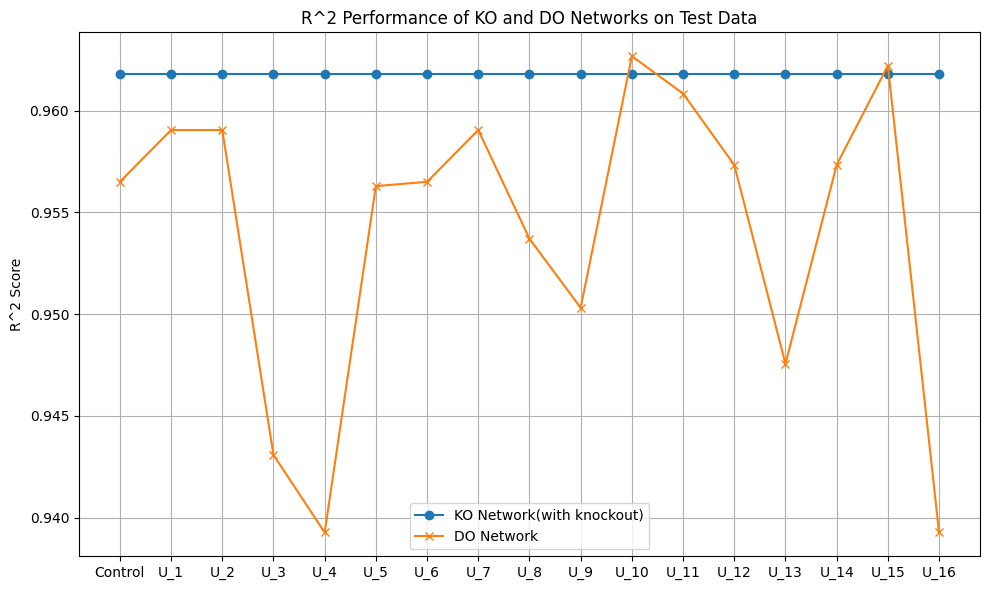

In [99]:

x = list(range(17))
plt.figure(figsize=(10, 6))
plt.plot(x, ko_r2_scores, label='KO Network(with knockout)', marker='o')
plt.plot(x, do_r2_scores, label='DO Network', marker='x')
plt.xticks(ticks=x, labels=["Control"] + [f"U_{i+1}" for i in x[:-1]]  )
plt.ylabel("R^2 Score")
plt.title("R^2 Performance of KO and DO Networks on Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Solution for Q 3

In [116]:
na_size = 1000
na_input = torch.randn(na_size, 50)

In [117]:
flyfruit_na = []

for i in range(16):
  flyfruit_na.append(FruitFlyNetwork(na_input, knockout=i, return_activation=True))

In [118]:
ko_knockout_na = []
for i in range(16):
  ko_knockout_na.append(KONetwork_withKnockout(na_input, knockout=i, return_activation=True))

r2_scores_ko = []
for i in range(16):
  r2_scores_ko.append((r2_score(flyfruit_na[i], ko_knockout_na[i]).item()))

In [119]:
do_na = []
for i in range(16):
  do_na.append(DO_Network(na_input, dropout=True, use_control=False, return_activation=True))

r2_scores_do = []
for i in range(16):
  r2_scores_do.append((r2_score(flyfruit_na[i], do_na[i]).item()))

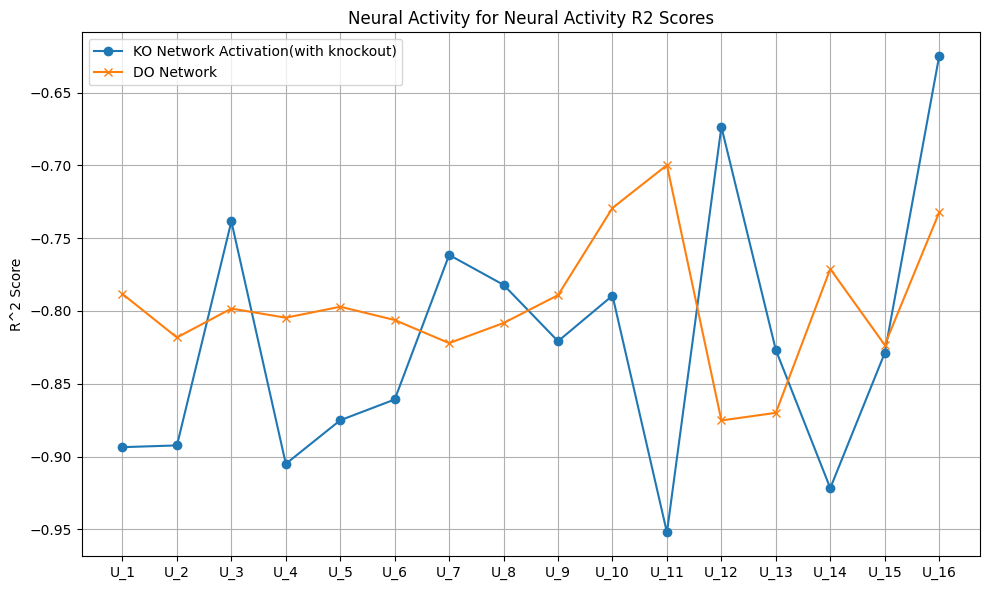

In [120]:
# draw newual activity ploy

x = list(range(16))
plt.figure(figsize=(10, 6))
plt.plot(x, r2_scores_ko, label='KO Network Activation(with knockout)', marker='o')
plt.plot(x, r2_scores_do, label='DO Network', marker='x')
plt.xticks(ticks=x, labels=[f"U_{i+1}" for i in x])
plt.ylabel("R^2 Score")
plt.title("Neural Activity for Neural Activity R2 Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()